In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os
import json
import shutil
import cv2
import numpy as np
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import cv2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Dataset/Vehicle_Detection.zip'

Archive:  /content/drive/MyDrive/Dataset/Vehicle_Detection.zip
   creating: Vehicle_Detection/Vehicle_Detection/
  inflating: Vehicle_Detection/Vehicle_Detection/_annotations_test.coco.json  
  inflating: Vehicle_Detection/Vehicle_Detection/_annotations_train.coco.json  
  inflating: Vehicle_Detection/Vehicle_Detection/_annotations_valid.coco.json  
   creating: Vehicle_Detection/Vehicle_Detection/test/
  inflating: Vehicle_Detection/Vehicle_Detection/test/00404_2oZz8iFzGXf_600x450_jpg.rf.491fb16724f51e6ac951d11de2c46cf1.jpg  
  inflating: Vehicle_Detection/Vehicle_Detection/test/00606_cDFhM4cd1rV_600x450_jpg.rf.65972d906206e09750925507f08db5d4.jpg  
  inflating: Vehicle_Detection/Vehicle_Detection/test/00a0a_4BRVgQRJKC1_600x450_jpg.rf.8dbe8c197538eeff5423a1cb871897a0.jpg  
  inflating: Vehicle_Detection/Vehicle_Detection/test/00L0L_hyJdEQyIBQV_600x450_jpg.rf.94c9052179d806a7e84e9e9aa90cade6.jpg  
  inflating: Vehicle_Detection/Vehicle_Detection/test/00p0p_2XPlWdcKXBs_600x450_jpg.rf.14

In [ ]:
train_json = '/content/Vehicle_Detection/Vehicle_Detection/_annotations_train.coco.json'
test_json = '/content/Vehicle_Detection/Vehicle_Detection/_annotations_test.coco.json'
valid_json = '/content/Vehicle_Detection/Vehicle_Detection/_annotations_valid.coco.json'
img_train = '/content/Vehicle_Detection/Vehicle_Detection/train'
img_valid = '/content/Vehicle_Detection/Vehicle_Detection/valid'
img_test = '/content/Vehicle_Detection/Vehicle_Detection/test'

In [ ]:
def make_dir(json_path, output_dir, img_dir):
  with open(json_path, 'r') as json_file:
      data = json.load(json_file)
  output_directory = output_dir
  os.makedirs(output_directory, exist_ok=True)
  for image in data.get("images", []):
      img_filename = image.get("file_name")
      category_id = None
      for annotation in data.get("annotations", []):
          if annotation.get("image_id") == image.get("id"):
              category_id = annotation.get("category_id")
              break

      if category_id is not None:
          category_info = next((cat for cat in data.get("categories", []) if cat.get("id") == category_id), None)
          if category_info:
              category_name = category_info.get("name")
              image_category_dir = os.path.join(output_directory, category_name)
              os.makedirs(image_category_dir, exist_ok=True)

              source_path = os.path.join(img_dir, img_filename)
              dest_path = os.path.join(image_category_dir, img_filename)
              if not os.path.exists(dest_path):
                  shutil.copy(source_path, dest_path)
  dir = output_directory
  return dir

In [ ]:
dir_train = make_dir(train_json, '/content/Training', img_train)
dir_test = make_dir(test_json, '/content/Testing', img_test)

In [ ]:
dir_valid = make_dir(valid_json, '/content/Valid', img_valid)

In [ ]:
img_width, img_height = 224, 224
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:

train_generator = train_datagen.flow_from_directory(
    dir_train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 2517 images belonging to 10 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    '/content/Valid',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 168 images belonging to 10 classes.


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

testing_generator = test_datagen.flow_from_directory(
    '/content/Testing',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 112 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

my_model = Sequential()
my_model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
my_model.add(Conv2D(128, (3, 3), activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))

my_model.add(Conv2D(64, (3, 3), activation='relu'))
my_model.add(Conv2D(64, (3, 3), activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))

my_model.add(Conv2D(64, (3, 3), activation='relu'))
my_model.add(Conv2D(64, (3, 3), activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))

my_model.add(Flatten())
my_model.add(Dense(256, activation='relu'))
my_model.add(Dense(128, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(10, activation='softmax'))

In [ ]:
my_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 128)     0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                   

In [ ]:
my_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
my_history =my_model.fit(train_generator,validation_data=validation_generator,epochs=100,batch_size=16)


Epoch 1/100
79/79 [==============================] - 83s 725ms/step - loss: 2.2804 - accuracy: 0.1307 - val_loss: 2.2797 - val_accuracy: 0.0714
Epoch 2/100
79/79 [==============================] - 52s 660ms/step - loss: 2.2604 - accuracy: 0.1315 - val_loss: 2.2692 - val_accuracy: 0.1845
Epoch 3/100
79/79 [==============================] - 53s 669ms/step - loss: 2.2635 - accuracy: 0.1303 - val_loss: 2.2748 - val_accuracy: 0.1845
Epoch 4/100
79/79 [==============================] - 53s 670ms/step - loss: 2.2551 - accuracy: 0.1414 - val_loss: 2.2724 - val_accuracy: 0.1845
Epoch 5/100
79/79 [==============================] - 56s 701ms/step - loss: 2.2595 - accuracy: 0.1319 - val_loss: 2.2732 - val_accuracy: 0.1845
Epoch 6/100
79/79 [==============================] - 52s 660ms/step - loss: 2.2541 - accuracy: 0.1331 - val_loss: 2.2777 - val_accuracy: 0.1845
Epoch 7/100
79/79 [==============================] - 53s 667ms/step - loss: 2.2562 - accuracy: 0.1395 - val_loss: 2.2740 - val_accuracy:

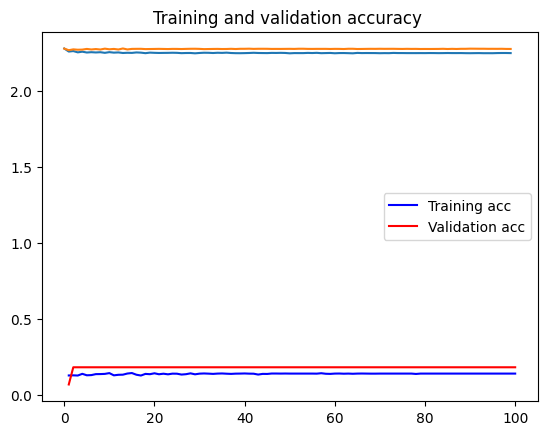

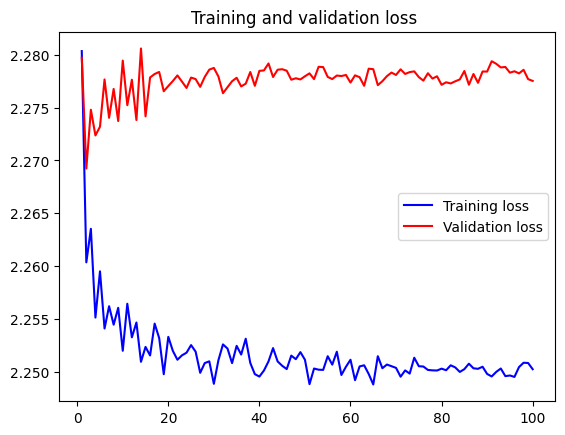

In [ ]:
import matplotlib.pyplot as plt
plt.plot(my_history.history['loss'])
plt.plot(my_history.history['val_loss'])


acc = my_history.history['accuracy']
val_acc = my_history.history['val_accuracy']


loss = my_history.history['loss']
val_loss = my_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy ')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss ')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model = load_model('/content/drive/MyDrive/my_model.h5')
predictions = model.predict(testing_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = testing_generator.classes
report = classification_report(true_labels, predicted_labels)
print(report)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


4/4 [==============================] - 4s 947ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        14
           6       0.20      1.00      0.33        22
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         7

    accuracy                           0.20       112
   macro avg       0.02      0.10      0.03       112
weighted avg       0.04      0.20      0.06       112

Confusion Matrix:
[[ 0  0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save('/content/drive/MyDrive/my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Using pretrained model MobileNetV2, this model is already been pretrained and imagenet weights are been used

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# trainable is false because, we dont want to again train on my dataset
base_model.trainable = False

In [ ]:
#the output has 10 classes(multi-class) so we are using softmax activation function

import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
epochs = 200
# train for more like 250, to better accuracy
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/200
79/79 [==============================] - 60s 588ms/step - loss: 2.2657 - accuracy: 0.2193 - val_loss: 1.8517 - val_accuracy: 0.3393
Epoch 2/200
79/79 [==============================] - 46s 588ms/step - loss: 1.9578 - accuracy: 0.3067 - val_loss: 1.6473 - val_accuracy: 0.3988
Epoch 3/200
79/79 [==============================] - 42s 533ms/step - loss: 1.8163 - accuracy: 0.3556 - val_loss: 1.4662 - val_accuracy: 0.5179
Epoch 4/200
79/79 [==============================] - 45s 566ms/step - loss: 1.6854 - accuracy: 0.3945 - val_loss: 1.4189 - val_accuracy: 0.4881
Epoch 5/200
79/79 [==============================] - 42s 531ms/step - loss: 1.6165 - accuracy: 0.4172 - val_loss: 1.3889 - val_accuracy: 0.4821
Epoch 6/200
79/79 [==============================] - 60s 765ms/step - loss: 1.5612 - accuracy: 0.4474 - val_loss: 1.3334 - val_accuracy: 0.5536
Epoch 7/200
79/79 [==============================] - 44s 557ms/step - loss: 1.5154 - accuracy: 0.4569 - val_loss: 1.3776 - val_accuracy:

In [ ]:
model.save('model_car.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/MyDrive/model_car.h5')


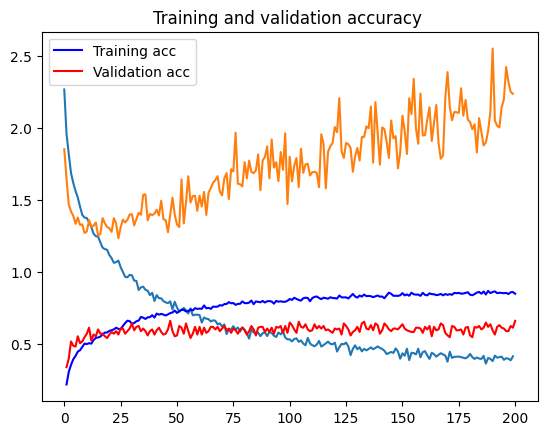

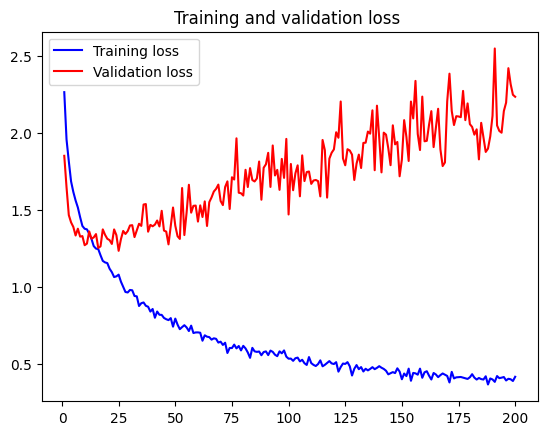

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy ')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss ')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model = load_model('/content/drive/MyDrive/model_car.h5')
predictions = model.predict(testing_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = testing_generator.classes
report = classification_report(true_labels, predicted_labels)
print(report)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


4/4 [==============================] - 3s 496ms/step
              precision    recall  f1-score   support

           0       0.20      0.17      0.18        12
           1       0.00      0.00      0.00        11
           2       0.08      0.08      0.08        13
           3       0.08      0.08      0.08        13
           4       0.00      0.00      0.00         2
           5       0.18      0.14      0.16        14
           6       0.26      0.32      0.29        22
           7       0.05      0.08      0.06        12
           8       0.33      0.50      0.40         6
           9       0.00      0.00      0.00         7

    accuracy                           0.15       112
   macro avg       0.12      0.14      0.12       112
weighted avg       0.14      0.15      0.14       112

Confusion Matrix:
[[2 1 2 2 0 1 1 1 2 0]
 [0 0 0 1 0 2 5 2 0 1]
 [0 2 1 1 0 3 3 3 0 0]
 [1 1 4 1 0 0 2 3 1 0]
 [0 0 0 0 0 0 0 2 0 0]
 [3 0 2 0 1 2 3 2 1 0]
 [2 2 3 2 0 2 7 3 1 0]
 [1 3 1 3